# APLICAÇÃO DE BOTTOM TRACKER E SWELL FILTER EM SÍSMICA MONOCANAL DE ALTA RESOLUÇÃO (.seg e .sgy)

### Importação de bibliotecas

In [1]:
import pandas as pd
import numpy as np
import segyio
import matplotlib.pyplot as plt

### Abrindo a linha

In [2]:
# Abre a linha sísmica como array e pega outras informações relevantes.
def segy2array(root):
    with segyio.open(root,mode='r+',ignore_geometry=True) as f:
        n_traces = f.tracecount
        sample_rate = segyio.tools.dt(f) / 1000
        n_samples = f.samples.size
        twt = f.samples
        data = f.trace.raw[:].T
        # Get all header keys
        headers = segyio.tracefield.keys
        # Initialize dataframe with trace id as index and headers as columns
        trace_headers = pd.DataFrame(index=range(1, n_traces + 1),
                          columns=headers.keys())
        # Fill dataframe with all header values
        for k, v in headers.items():
            trace_headers[k] = f.attributes(v)[:]
    dt=sample_rate/1000 
    return n_traces,sample_rate,n_samples,twt,data,headers,trace_headers,dt

In [3]:
root = "TRANSITO_H1_H2_RAW_000.sgy"
n_traces,sample_rate,n_samples,twt,data,headers,trace_headers,dt = segy2array(root)

print(f'Number of traces: {n_traces}')
print(f'Sample rate: {sample_rate} seconds')
print(f'Number of samples per shot: {n_samples}')
print(f'dt: {dt} ms')
print(f'data.shape: {data.shape}')
print(f'twt.shape: {twt.shape}')
print(f'len(headers): {len(headers)}')
print(f'trace_headers.shape: {trace_headers.shape}')

Number of traces: 1413
Sample rate: 0.06 seconds
Number of samples per shot: 2222
dt: 5.9999999999999995e-05 ms
data.shape: (2222, 1413)
twt.shape: (2222,)
len(headers): 91
trace_headers.shape: (1413, 91)


### Calculando bottom tracker

In [4]:
# A função de bottom tracker baseia-se no algoritmo de spline cúbica, que simula a ondulação do fundo marinho.
def bottom_tracker(data,amp,inicio_varredura,dt):
    '''
    Função de detecção do fundo marinho (bottom tracker), utilizando algoritmo de spline cúbica.

    Parameters
    ----------
    data : numpy array com linhas = n_samples e colunas = n_traces.
    amp : threshold de amplitude para o bottom tracker
    inicio_varredura : tempo em ms que será iniciada a busca pelo fundo marinho.É recomendado colocar algum valor 
    para não ter problemas com ondas diretas.
    dt : intervalo de tempo, em ms, entre um shot e outro.

    Returns
    -------
    thresh : array de pontos (n_traces,1) dos thresholds de cada traço dado pela amplitude estabelecida.
    cs_x : eixo X da spline cúbica criada.
    cs_y : eixo Y da spline cúbica criada.

    '''
    # Detectando o fundo para cada traço
    thresh = np.zeros((data.shape[1],1))
    inicio = int(inicio_varredura/(dt*1000))
    for j in range(data.shape[1]):
        for i in range(inicio,data.shape[0]):
            if abs(data[i,j]) >= amp:
                thresh[j] = i
                break
    # Criando a spline cúbica
    import scipy.interpolate
    cs = scipy.interpolate.CubicSpline(range(n_traces),thresh*dt*1000, axis=0)
    cs_x = np.arange(0,n_traces,0.1)
    cs_y = cs(np.arange(0,n_traces,0.1))
    return thresh, cs_x, cs_y

In [5]:
amp = 1000
inicio_varredura = 45 # Aqui eu defino essa variável para não ter problema com as ondas diretas. A detecção começa a partir dos 45ms.
thresh, cs_x, cs_y = bottom_tracker(data,amp,inicio_varredura,dt)

### Aplicando o filtro de swell

In [6]:
# Função de apoio para a função do swell filter.
# A função SHIFT faz a mesma coisa que a pd.DataFrame.rolling. Entretanto, é melhor pois admite valores negativos.
def shift(arr, num, fill_value=0):
    result = np.empty_like(arr)
    if num > 0:
        result[:num] = fill_value
        result[num:] = arr[:-num]
    elif num < 0:
        result[num:] = fill_value
        result[:num] = arr[-num:]
    else:
        result[:] = arr
    return result

In [7]:
# A função do swell filter aproxima a spline cúbica à uma média móvel centralizada.
def swell_filter(data,thresh,sma_window=50):
    '''
    FILTRAGEM DE SWELL.

    Parameters
    ----------
    thresh : são os samples, de cada traço, que registraram o fundo marinho por uma dada amplitude anteriormente.
    sma_window : janela da média móvel. Padrão é 50.

    Returns
    -------
    result : array de dados com swell corrigido.
    sma : curva de aproximação do fundo marinho (n_traces,1)

    '''
    # Definindo fundo marinho de referência para correção do swell
    sma = pd.DataFrame(thresh*dt*1000).rolling(sma_window,center=True).mean()
    # Definindo a diferença em tempo entre o bottom tracker e a superfície de diferença (SMA)
    diff = sma-thresh*dt*1000
    diff = diff/(dt*1000)
    diff = np.nan_to_num(diff).astype(int)
    # Corrigindo o dado para a superfície de referência (SMA)
    result = np.empty_like(data)
    for i in range(len(diff)):
        result[:,i] = shift(data[:,i],diff[i][0])
    result = np.nan_to_num(result).astype(int)
    sma = np.nan_to_num(np.array(sma))
    return(result, sma)

In [8]:
data_filtrado, sma = swell_filter(data,thresh,sma_window=50)

### Plots do resultado


In [9]:
# Definindo extent e percentual para filtrar amplitudes e visualizar melhor a sísmica
percentile=np.percentile(data,99)
horizontal_min = 0
horizontal_max = (len(data[0])-1)
vertical_min = (((len(data) - 1)*dt)*1000)
vertical_max = 0
extent = [horizontal_min,horizontal_max,vertical_min,vertical_max]

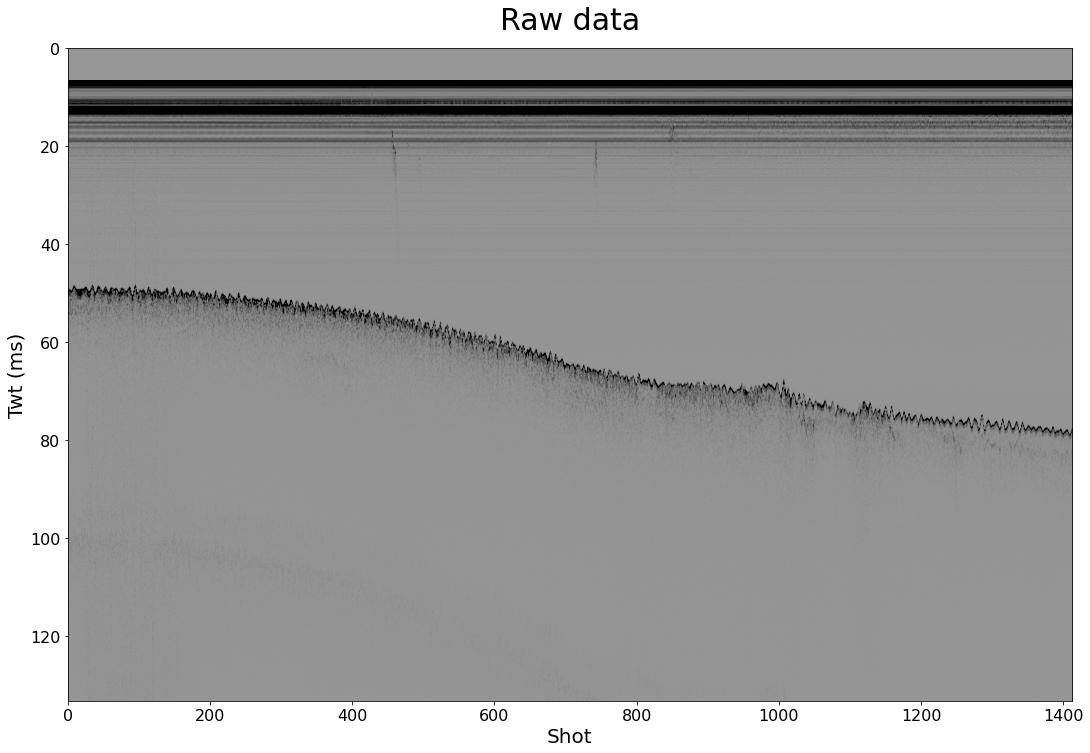

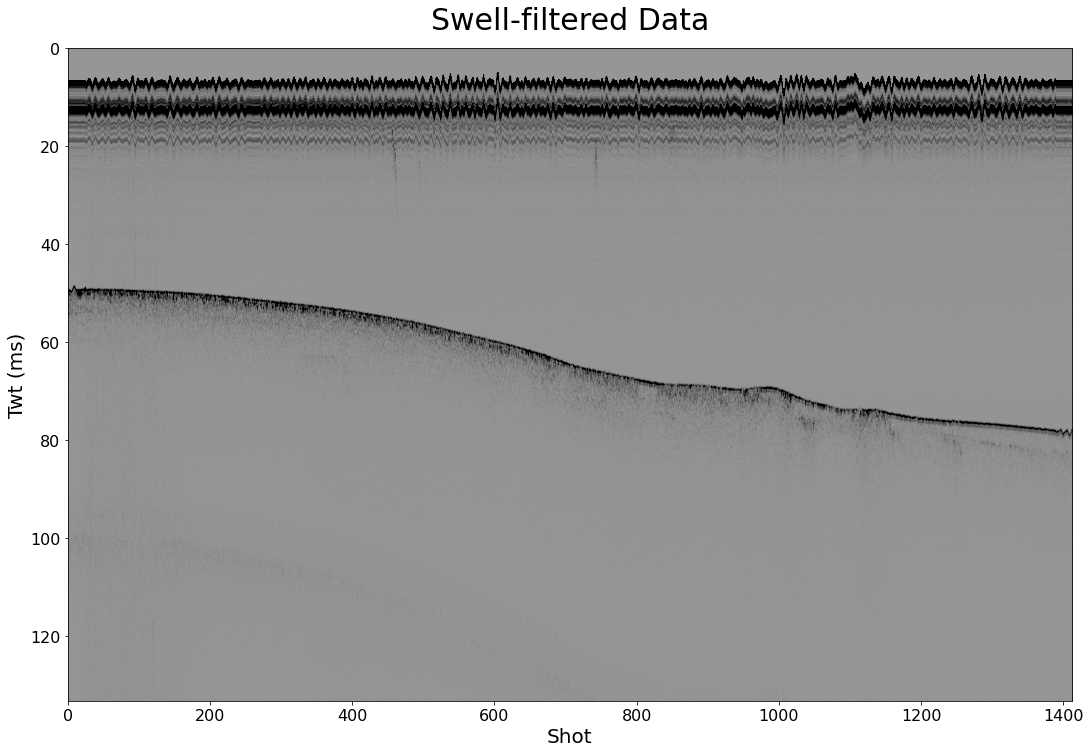

In [10]:
# plot da imagem sismica ANTES
plt.figure(figsize=(18,12))
plt.xlabel('Shot',fontsize=20); 
plt.ylabel('Twt (ms)',fontsize=20,x=0);
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.title('Raw data',fontsize=30,y=1.02);
plt.imshow(np.abs(data),aspect='auto',vmin=-percentile,vmax=percentile,cmap='Greys',extent=extent,origin='upper')
plt.show()

# plot da imagem sismica DEPOIS
plt.figure(figsize=(18,12))
plt.xlabel('Shot',fontsize=20); 
plt.ylabel('Twt (ms)',fontsize=20,x=0);
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.title('Swell-filtered Data',fontsize=30,y=1.02);
plt.imshow(np.abs(data_filtrado),aspect='auto',vmin=-percentile,vmax=percentile,cmap='Greys',extent=extent,origin='upper')
plt.show()

### Plots do resultado detalhado

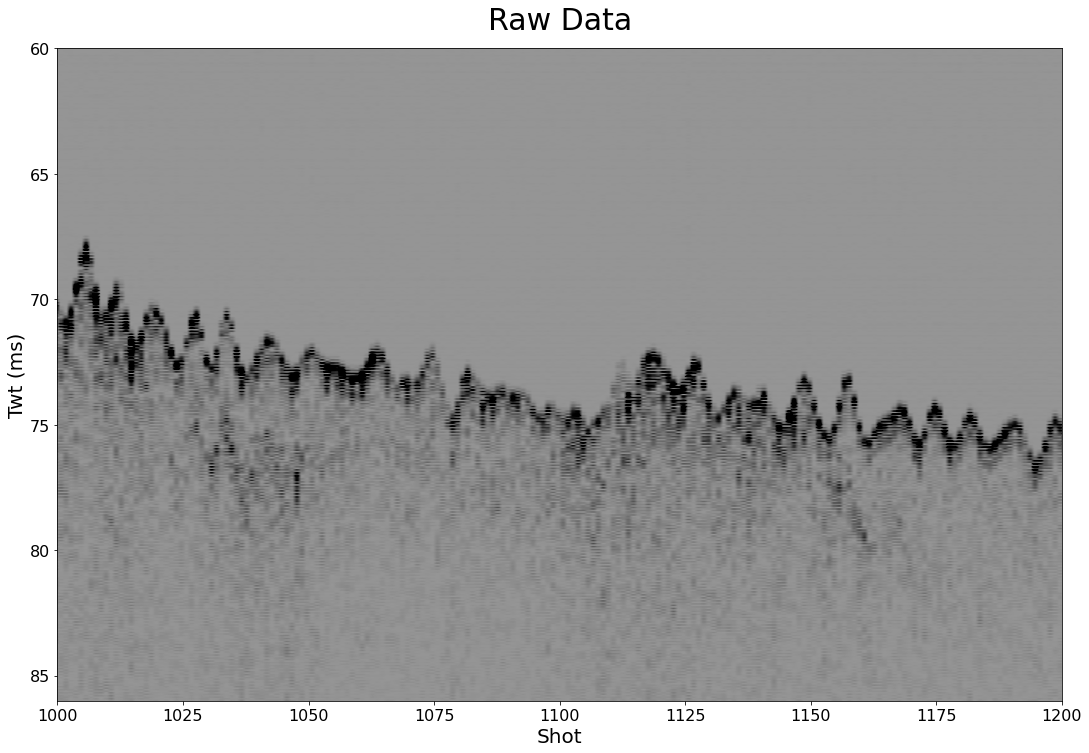

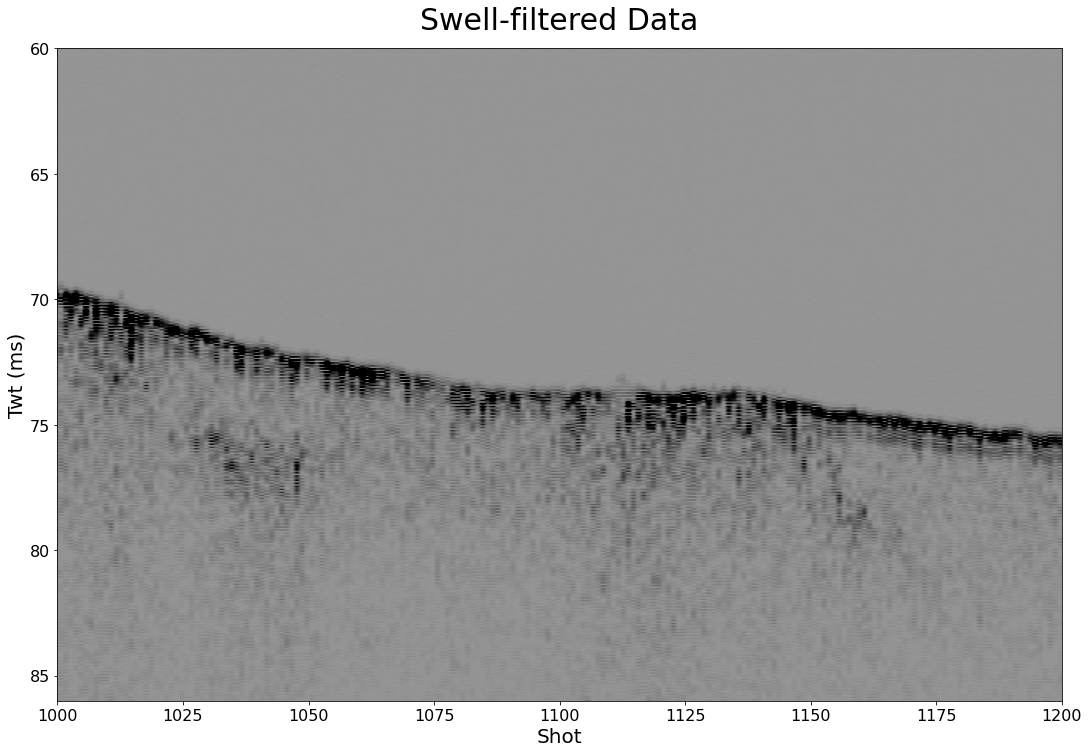

In [11]:
# plot da imagem sismica ANTES DETALHADO
plt.figure(figsize=(18,12))
plt.xlabel('Shot',fontsize=20); 
plt.ylabel('Twt (ms)',fontsize=20,x=0);
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.title('Raw Data',fontsize=30,y=1.02);
plt.imshow(np.abs(data),aspect='auto',vmin=-percentile,vmax=percentile,cmap='Greys',extent=extent,origin='upper')
plt.xlim(1000,1200)
plt.ylim(86,60)
plt.show()

# plot da imagem sismica DEPOIS DETALHADO
plt.figure(figsize=(18,12))
plt.xlabel('Shot',fontsize=20); 
plt.ylabel('Twt (ms)',fontsize=20,x=0);
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.title('Swell-filtered Data',fontsize=30,y=1.02);
plt.imshow(np.abs(data_filtrado),aspect='auto',vmin=-percentile,vmax=percentile,cmap='Greys',extent=extent,origin='upper')
plt.xlim(1000,1200)
plt.ylim(86,60)
plt.show()

### Plots do bottom tracker e da SMA

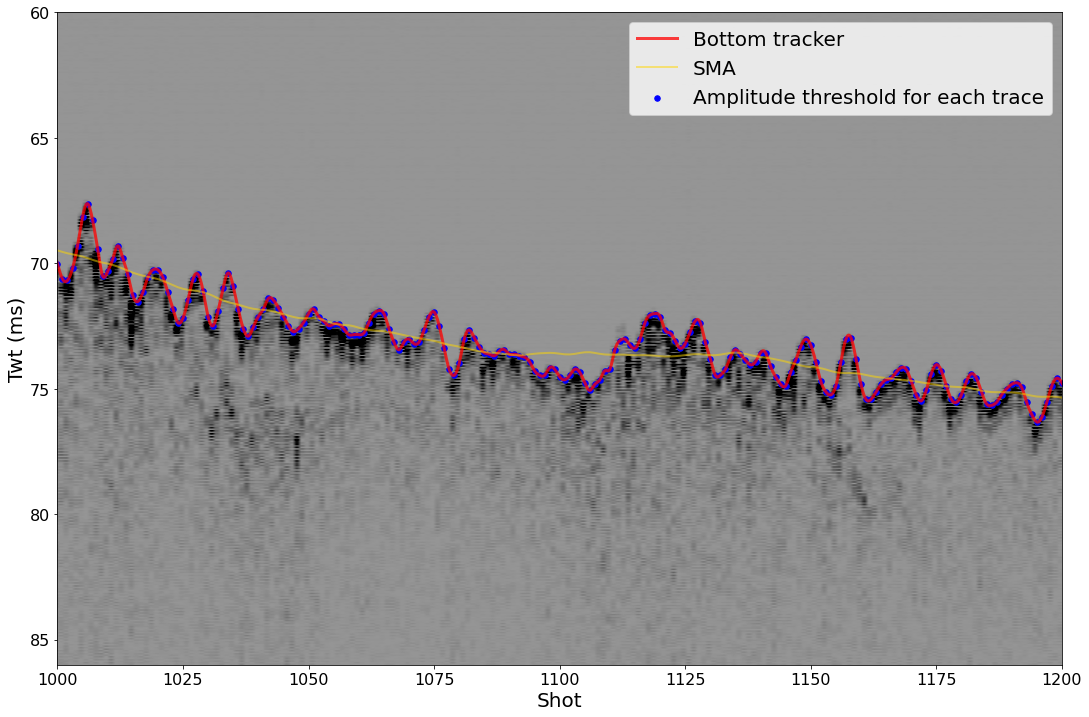

In [12]:
# plot da imagem sismica
plt.figure(figsize=(18,12))
plt.xlabel('Shot',fontsize=20); 
plt.ylabel('Twt (ms)',fontsize=20,x=0);
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
#plt.title('ANTES',fontsize=30,y=1.02);
plt.xlim(800,1200)
plt.imshow(np.abs(data),aspect='auto',vmin=-percentile,vmax=percentile,cmap='Greys',extent=extent,origin='upper')
plt.xlim(1000,1200)
plt.ylim(86,60)

#plot da spline
plt.plot(cs_x,cs_y,color='red',linewidth=3, alpha=0.75,label='Bottom tracker')

# plot do threshold de amplitude
plt.scatter(range(n_traces),thresh*dt*1000,color='blue',s=30,label='Amplitude threshold for each trace')

# plot SMA
plt.plot(range(n_traces),sma,color='gold',alpha=0.5,linewidth=2,label='SMA')

plt.legend(prop={'size': 20})
plt.show()

### Top muting em profundidade fixa

In [13]:
def static_top_muting(data,time,dt):
    data_static_mute = data.copy()
    data_static_mute[0:int(time/(dt*1000)),:] = 0
    return data_static_mute

In [14]:
time = 45 # ms
data_filtrado_static_mute = static_top_muting(data_filtrado,time,dt)

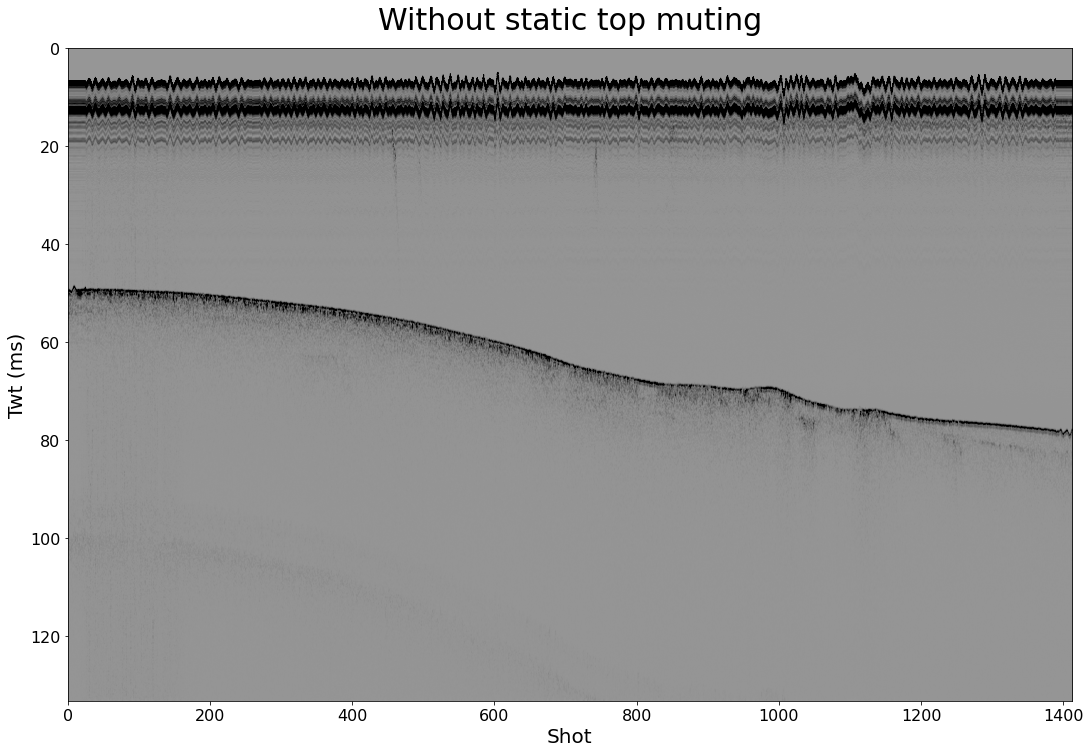

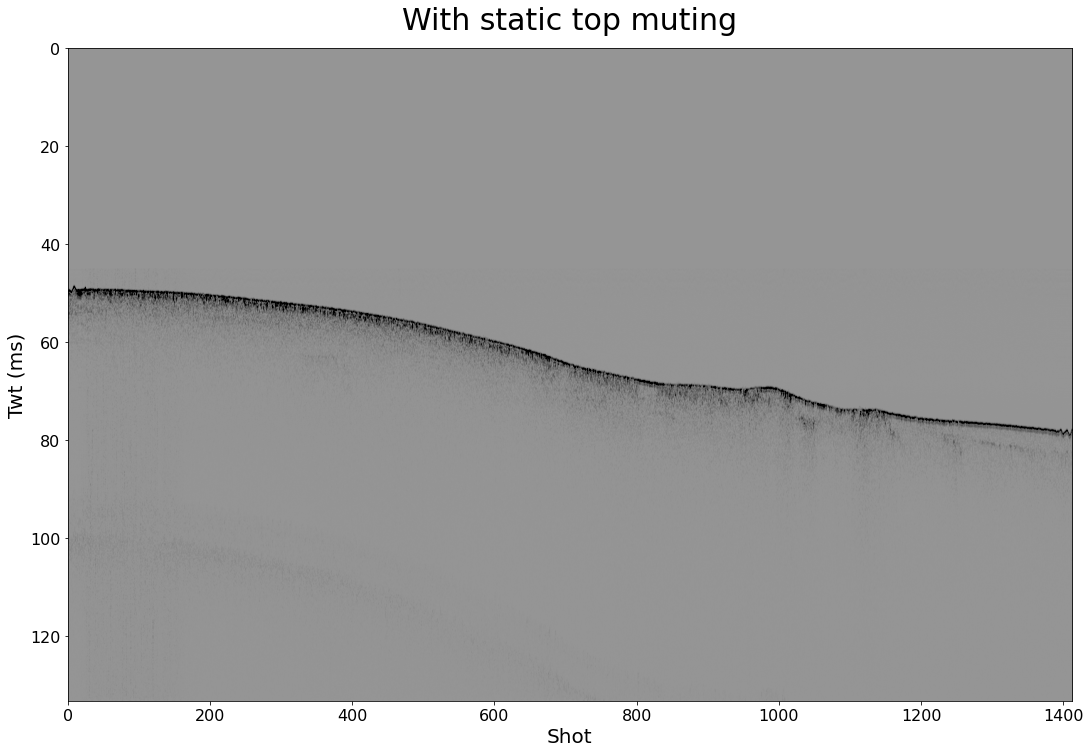

In [15]:
# Plot sem top muting estático
plt.figure(figsize=(18,12))
plt.xlabel('Shot',fontsize=20); 
plt.ylabel('Twt (ms)',fontsize=20,x=0);
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.title('Without static top muting',fontsize=30,y=1.02);
plt.imshow(np.abs(data_filtrado),aspect='auto',vmin=-percentile,vmax=percentile,cmap='Greys',extent=extent,origin='upper')
plt.show()

# Plot com top muting estático
plt.figure(figsize=(18,12))
plt.xlabel('Shot',fontsize=20); 
plt.ylabel('Twt (ms)',fontsize=20,x=0);
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.title('With static top muting',fontsize=30,y=1.02);
plt.imshow(np.abs(data_filtrado_static_mute),aspect='auto',vmin=-percentile,vmax=percentile,cmap='Greys',extent=extent,origin='upper')
plt.show()

### Top muting based on bottom-tracker

In [16]:
def dynamic_top_muting(data,bottom,dt):
    data_dynamic_top_muting = data.copy()
    for i in range(data_dynamic_top_muting.shape[1]):
        if int((bottom[i])/(dt*1000)) == 0:
            data_dynamic_top_muting[0:int((bottom[i])/(dt*1000)),i] = 0
        else:
            data_dynamic_top_muting[0:int((bottom[i])/(dt*1000))-1,i] = 0
    return data_dynamic_top_muting

In [17]:
data_filtrado_dynamic_top_mute = dynamic_top_muting(data_filtrado,sma,dt)

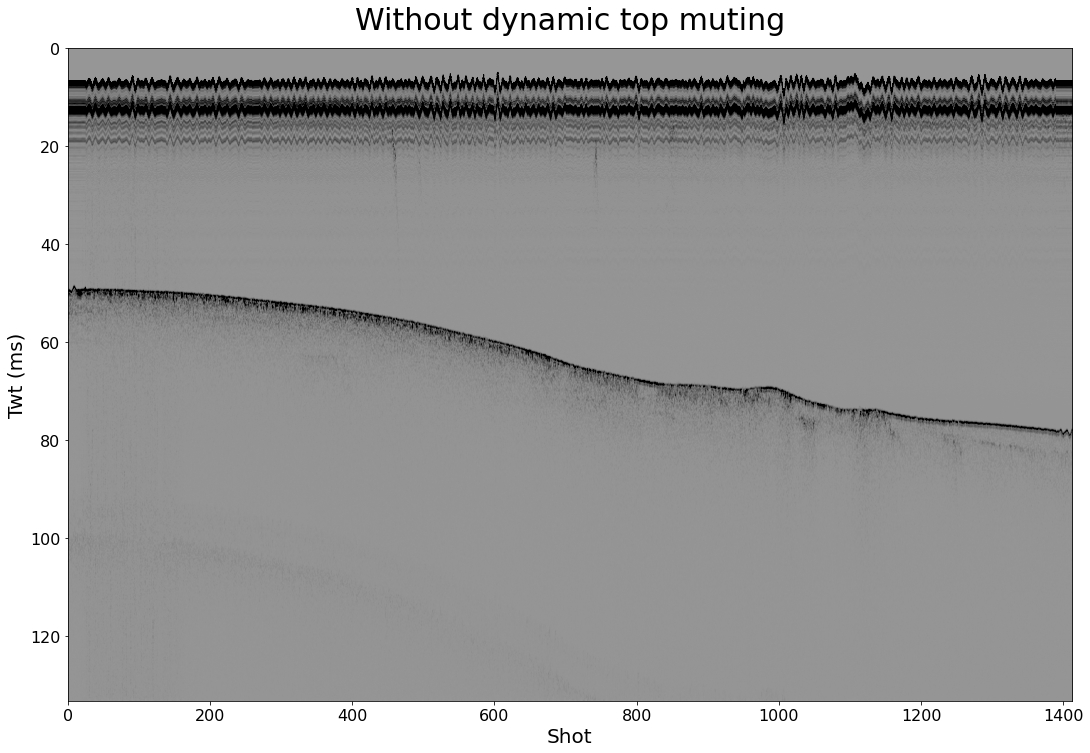

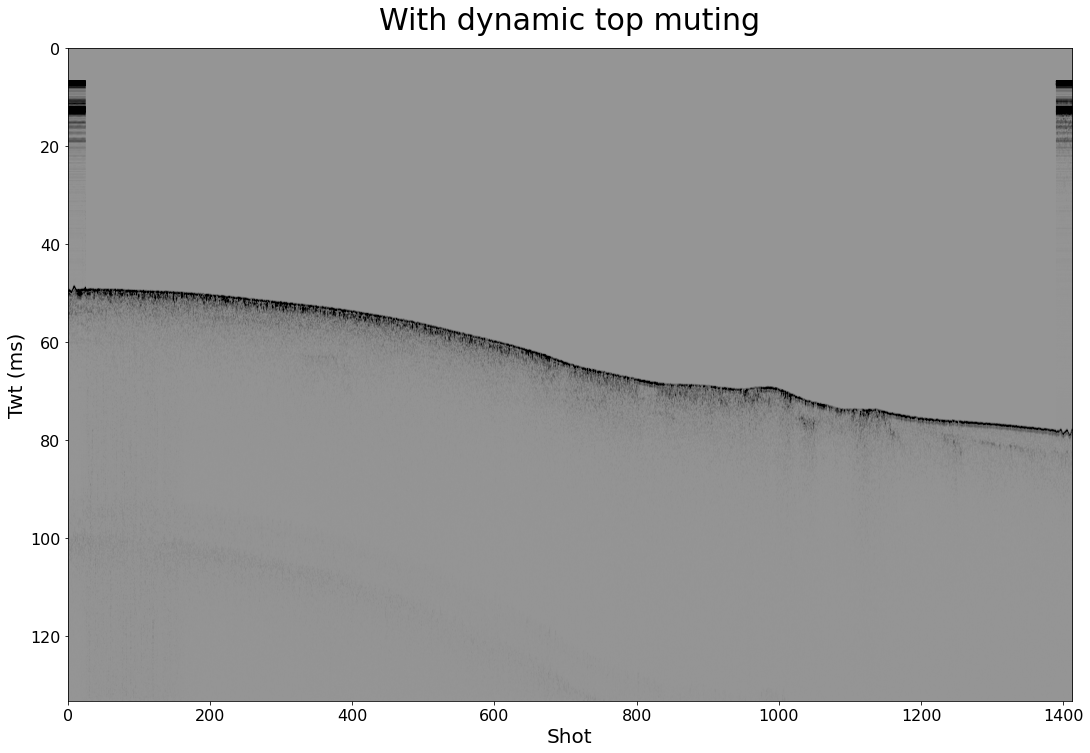

In [18]:
plt.figure(figsize=(18,12))
plt.xlabel('Shot',fontsize=20); 
plt.ylabel('Twt (ms)',fontsize=20,x=0);
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.title('Without dynamic top muting',fontsize=30,y=1.02);
plt.imshow(np.abs(data_filtrado),aspect='auto',vmin=-percentile,vmax=percentile,cmap='Greys',extent=extent,origin='upper')
plt.show()

plt.figure(figsize=(18,12))
plt.xlabel('Shot',fontsize=20); 
plt.ylabel('Twt (ms)',fontsize=20,x=0);
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.title('With dynamic top muting',fontsize=30,y=1.02);
plt.imshow(np.abs(data_filtrado_dynamic_top_mute),aspect='auto',vmin=-percentile,vmax=percentile,cmap='Greys',extent=extent,origin='upper')
plt.show()

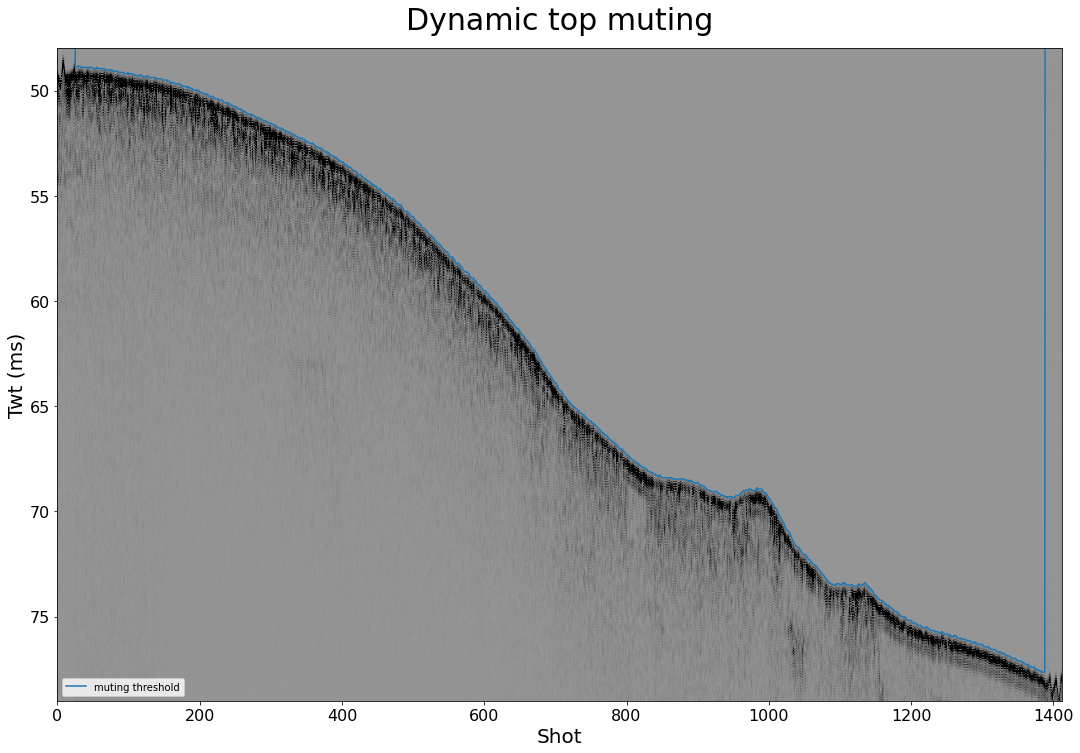

In [19]:
plt.figure(figsize=(18,12))
plt.xlabel('Shot',fontsize=20); 
plt.ylabel('Twt (ms)',fontsize=20,x=0);
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.title('Dynamic top muting',fontsize=30,y=1.02)
lista = []
for i in range(data_filtrado_dynamic_top_mute.shape[1]):
    lista.append(np.argmax(data_filtrado_dynamic_top_mute[:,i]!=0)-1)
plt.plot(range(n_traces),np.array(lista)*dt*1000,label='muting threshold')
plt.imshow(np.abs(data_filtrado_dynamic_top_mute),aspect='auto',vmin=-percentile,vmax=percentile,cmap='Greys',extent=extent,origin='upper')
plt.ylim(79,48)
plt.legend()
plt.show()